#### 2) Training Decoders in Practice

Now that we have discussed the conceptual foundations, strategies and techniques involved, we will provide detailed examples of how train decoders via the procedures discussed. In particular, in this notebook we will walk through a very simple script for training a decoder with a given set of hyper-parameters, providing the foundation for a later discussion concerning how to obtain optimal decoders for a range of error rates through an iterative training procedure involving a hyper-parameter optimization for each error rate (see the companion notebook "Large Scale Iterative Training"). 

##### 2a) Requirements

The following packages are required, and can be installed via PIP:

<ol>
  <li> Python 3 (with numpy and scipy)</li>
  <li> tensorflow </li>
  <li> keras </li> 
  <li> gym </li> 
</ol> 

In addition, a modified version of the Keras-RL package is required, which should be installed from <a href="https://github.com/R-Sweke/keras-rl">this fork</a>

##### 2b) A Simple Training Script

We begin by importing all required packages and methods:

In [9]:
import numpy as np
import keras
import tensorflow
import gym

from Function_Library import *
from Environments import *

import rl as rl
from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy, EpsGreedyQPolicy, LinearAnnealedPolicy, GreedyQPolicy
from rl.memory import SequentialMemory
from rl.callbacks import FileLogger

import json
import copy
import sys
import os
import shutil
import datetime
import pickle

We then proceed by providing all required hyperparameters and physical configuration settings. In order to allow for easier grid searching and incremented training later on we choose to split all hyperparameters into two categories:

   - fixed configs: These remain constant during the course of a grid search or incremented training procedure.
   - variable configs: We will later set up training grids over these hyperparameters.
    
In particular, the fixed parameters one must provide are:

   1. **d**: The lattice width (equal to the lattice height)
   - **use_Y**: If true then the agent can perform Y Pauli flips directly, if False then the agent can only perform X and Z Pauli flips.
   - **train_freq**: The number of agent-environment interaction steps which occur between each updating of the agent's weights.
   - **batch_size**: The size of batches used for calculating loss functions for gradient descent updates of agent weights.
   - **print_freq**: Every print_freq episodes the statistics of the training procedure will be logged.
   - **rolling_average_length**: The number of most recent episodes over which any relevant rolling average will be calculated.
   - **stopping_patience**: The number of episodes after which no improvement will result in the early stopping of the training procedure.
   - **error_model**: A string in ["X", "DP"], specifiying the noise model of the environment as X flips only or depolarizing noise.
   - **c_layers**: A list of lists specifying the structure of the convolutional layers of the agent deepQ network. Each inner list describes a layer and has the form [num_filters, filter_width, stride].
   - **ff_layers**: A list of lists specifying the structure of the feed-forward neural network sitting on top of the convolutional neural network. Each inner list has the form [num_neurons, output_dropout_rate].
   - **max_timesteps**: The maximum number of training timesteps allowed.
   - **volume_depth**: The number of syndrome measurements taken each time a new syndrome extraction is performed - i.e. the depth of the syndrome volume passed to the agent.
   - **testing_length**: The number of episodes uses to evaluate the trained agents performance. 
   - **buffer_size**: The maximum number of experience tuples held in the memory from which the update batches for agent updating are drawn.
   - **dueling**: A boolean indicating whether or not a [dueling architecture](https://arxiv.org/abs/1511.06581) should be used.
   - **masked_greedy**: A boolean which indicates whether the agent will only be allowed to choose legal actions (actions next to an anyon or previously flipped qubit) when acting greedily (i.e. when choosing actions via the argmax of the Q-values)
   - **static_decoder**: For training within the fault tolerant setting (multi-cycle decoding) this should always be set to True.
   
In addition, the parameters which we will later incrementally vary or grid search around are:

   1. **p_phys**: The physical error probability
   2. **p_meas**: The measurement error probability
   3. **success_threshold**: The qubit lifetime rolling average at which training has been deemed succesfull and will be stopped.
   4. **learning_starts**: The number of initial steps taken to contribute experience tuples to memory before any weight updates are made.
   5. **learning_rate**: The learning rate for gradient descent optimization (via the Adam optimizer)
   6. **exploration_fraction**: The number of time steps over which epsilon, the parameter controlling the probability of a random explorative action, is annealed.
   7. **max_eps**: The initial maximum value of epsilon.
   8. **target_network_update_freq**: In order to achieve stable training, a target network is cloned off from the active deepQ agent every target_network_update_freq interval of steps. This target network is then used to generate the target Q-function over the following interval.
   9. **gamma**: The discount rate used for calculating the expected discounted cumulative return (the Q-values).
   10. **final_eps**: The final value at which annealing of epsilon will be stopped.
   
Furthermore, in addition to all the above parameters one must provide a directory into which results and training progress as logged, as well as the path to a pre-trained referee decoder. Here e provide two pre-trained feed forward classification based referee decoders, one for X noise and one for DP noise. However, in principle any perfect-measurement decoding algorithm (such as MWPM) could be used here.

In [2]:
fixed_configs = {"d": 5,
                "use_Y": False,
                "train_freq": 1,
                "batch_size": 32,
                "print_freq": 250,
                "rolling_average_length": 500,
                "stopping_patience": 500,
                "error_model": "X",
                "c_layers": [[64,3,2],[32,2,1],[32,2,1]],
                "ff_layers": [[512,0.2]],
                "max_timesteps": 1000000,
                "volume_depth": 5,
                "testing_length": 101,
                "buffer_size": 50000,
                "dueling": True,
                "masked_greedy": False,
                "static_decoder": True}

variable_configs = {"p_phys": 0.001,
                    "p_meas": 0.001,
                    "success_threshold": 10000,
                    "learning_starts": 1000,
                    "learning_rate": 0.00001,
                    "exploration_fraction": 100000,
                    "max_eps": 1.0,
                    "target_network_update_freq": 5000,
                    "gamma": 0.99,
                    "final_eps": 0.02}

logging_directory = os.path.join(os.getcwd(),"logging_directory/")
static_decoder_path = os.path.join(os.getcwd(),"referee_decoders/nn_d5_X_p5")


all_configs = {}

for key in fixed_configs.keys():
    all_configs[key] = fixed_configs[key]

for key in variable_configs.keys():
    all_configs[key] = variable_configs[key]

static_decoder = load_model(static_decoder_path)                                                 
logging_path = os.path.join(logging_directory,"training_history.json")
logging_callback = FileLogger(filepath = logging_path,interval = all_configs["print_freq"])

Now that we have specified all the required parameters we can instantiate our environment:

In [3]:
env = Surface_Code_Environment_Multi_Decoding_Cycles(d=all_configs["d"], 
    p_phys=all_configs["p_phys"], 
    p_meas=all_configs["p_meas"],  
    error_model=all_configs["error_model"], 
    use_Y=all_configs["use_Y"], 
    volume_depth=all_configs["volume_depth"],
    static_decoder=static_decoder)

The environment class is defined to mirror the environments of [https://gym.openai.com/](openAI gym), and such contains the required "reset" and "step" methods, via which the agent can interact with the environment, in addition to decoding specific methods and attributes whose details can be found in the relevant method docstrings.

We can now proceed to define the agent. We being by specifying the memory to be used, as well as the exploration and testing policies.

In [4]:
memory = SequentialMemory(limit=all_configs["buffer_size"], window_length=1)

policy = LinearAnnealedPolicy(EpsGreedyQPolicy(masked_greedy=all_configs["masked_greedy"]), 
    attr='eps', value_max=all_configs["max_eps"], 
    value_min=all_configs["final_eps"], 
    value_test=0.0, 
    nb_steps=all_configs["exploration_fraction"])

test_policy = GreedyQPolicy(masked_greedy=True)

Finally, we can then build the deep convolutional neural network which will represent our Q-function and compile our agent.

In [5]:
model = build_convolutional_nn(all_configs["c_layers"], 
                               all_configs["ff_layers"], 
                               env.observation_space.shape, 
                               env.num_actions)

dqn = DQNAgent(model=model, 
               nb_actions=env.num_actions, 
               memory=memory, 
               nb_steps_warmup=all_configs["learning_starts"], 
               target_model_update=all_configs["target_network_update_freq"], 
               policy=policy,
               test_policy = test_policy,
               gamma = all_configs["gamma"],
               enable_dueling_network=all_configs["dueling"])  


dqn.compile(Adam(lr=all_configs["learning_rate"]))

With both the agent and the environment specified, it is then possible to train the agent by calling the agent's "fit" method. If you want to run this on a single computer, be careful, it may take up to 12 hours!

In [6]:
now = datetime.datetime.now()
started_file = os.path.join(logging_directory,"started_at.p")
pickle.dump(now, open(started_file, "wb" ) )

history = dqn.fit(env, 
  nb_steps=all_configs["max_timesteps"], 
  action_repetition=1, 
  callbacks=[logging_callback], 
  verbose=2,
  visualize=False, 
  nb_max_start_steps=0, 
  start_step_policy=None, 
  log_interval=all_configs["print_freq"],
  nb_max_episode_steps=None, 
  episode_averaging_length=all_configs["rolling_average_length"], 
  success_threshold=all_configs["success_threshold"],
  stopping_patience=all_configs["stopping_patience"],
  min_nb_steps=all_configs["exploration_fraction"],
  single_cycle=False)

Training for 1000000 steps ...
-----------------
                
Episode: 250
Step: 2476/1000000
This Episode Steps: 13
This Episode Reward: 0.0
This Episode Duration: 0.202s
Rolling Lifetime length: 43.040
Best Lifetime Rolling Avg: 43.34016393442623
Best Episode: 243
Time Since Best: 6
Has Succeeded: False
Stopped Improving: False
Metrics: loss: 0.028801, mean_q: 0.170932, mean_eps: 0.975804
Total Training Time: 26.474s

-----------------
                
Episode: 500
Step: 5004/1000000
This Episode Steps: 8
This Episode Reward: 0.0
This Episode Duration: 0.134s
Rolling Lifetime length: 42.830
Best Lifetime Rolling Avg: 44.064245810055866
Best Episode: 357
Time Since Best: 142
Has Succeeded: False
Stopped Improving: False
Metrics: loss: 0.044142, mean_q: 0.149415, mean_eps: 0.951005
Total Training Time: 68.114s

-----------------
                
Episode: 750
Step: 7322/1000000
This Episode Steps: 12
This Episode Reward: 3.0
This Episode Duration: 0.187s
Rolling Lifetime length: 41.

-----------------
                
Episode: 5500
Step: 76163/1000000
This Episode Steps: 83
This Episode Reward: 29.0
This Episode Duration: 1.217s
Rolling Lifetime length: 153.740
Best Lifetime Rolling Avg: 153.74
Best Episode: 5499
Time Since Best: 0
Has Succeeded: False
Stopped Improving: False
Metrics: loss: 0.287667, mean_q: 3.327248, mean_eps: 0.254014
Total Training Time: 1194.271s

-----------------
                
Episode: 5750
Step: 92208/1000000
This Episode Steps: 154
This Episode Reward: 94.0
This Episode Duration: 2.171s
Rolling Lifetime length: 300.200
Best Lifetime Rolling Avg: 300.2
Best Episode: 5749
Time Since Best: 0
Has Succeeded: False
Stopped Improving: False
Metrics: loss: 0.386786, mean_q: 4.670010, mean_eps: 0.097121
Total Training Time: 1428.460s

-----------------
                
Episode: 6000
Step: 165198/1000000
This Episode Steps: 476
This Episode Reward: 409.0
This Episode Duration: 6.908s
Rolling Lifetime length: 1951.740
Best Lifetime Rolling Avg: 19

As you can see above, during the training procedure various statistics are logged, both to stdout and to file in the specified directory. As you may notice above we manually stopped training after approximately 7000 seconds while the agent was still improving, and before it has reached the specified success threshold.

In order to evaluate the agent later on, or apply the agent in a production decoding scenario we can easily save the weights:

In [7]:
weights_file = os.path.join(logging_directory, "dqn_weights.h5f")
dqn.save_weights(weights_file, overwrite=True)

And finally, in order to evaluate the training procedure we may be interested in viewing any of the metrics which were logged. These are all saved within the history.history dictionary. For example, we are often most interested in analyzing the training procedure by looking at the rolling average of the qubit lifetime, which we can do as follows:

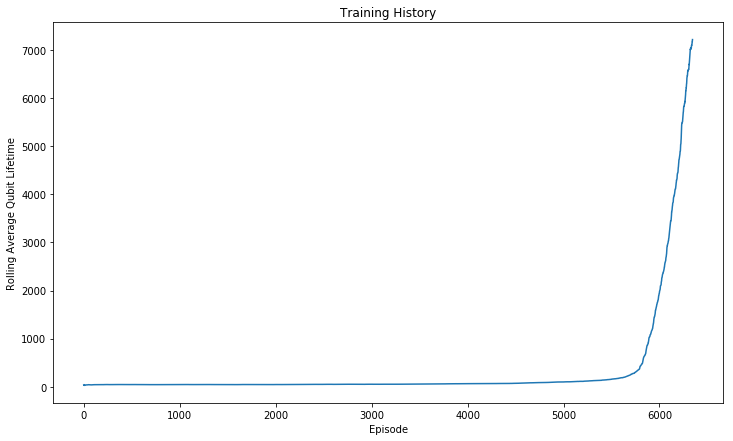

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline

training_history = history.history["episode_lifetimes_rolling_avg"]

plt.figure(figsize=(12,7))
plt.plot(training_history)
plt.xlabel('Episode')
plt.ylabel('Rolling Average Qubit Lifetime')
_ = plt.title("Training History")

From the above plot one can see that during the exploration phase the agent was unable to do well, due to constant exploratory random actions, but was able to exploit this knowledge effectively once the exploration probability became sufficiently low. Again, it is also clear that the agent was definitely still learning and improving when we chose to stop the training procedure.